In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

In [13]:
df_train = pd.read_csv('../data/processed/train.csv')
df_val = pd.read_csv('../data/processed/val.csv')

df = pd.concat([df_train, df_val])
df.head(3)

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute,Date,Day of Week
0,791,1,1991,1,2,68.00,Swipe Transaction,2027553650310142703,Burke,VA,22015.0,5541,NaN,0,7,10,1991-01-02,Ср
1,791,1,1991,1,2,-68.00,Swipe Transaction,2027553650310142703,Burke,VA,22015.0,5541,NaN,0,7,17,1991-01-02,Ср
2,791,1,1991,1,2,113.62,Swipe Transaction,2027553650310142703,Burke,VA,22015.0,5541,NaN,0,7,21,1991-01-02,Ср


In [15]:
# Освобождаем память
df_train = None
df_val = None

In [16]:
df.describe()

,User,Card,Year,Month,Day,Amount,Merchant Name,Zip,MCC,Is Fraud?,Hour,Minute
count,2.232646e+07,2.232646e+07,2.232646e+07,2.232646e+07,2.232646e+07,2.232646e+07,2.232646e+07,1.972173e+07,2.232646e+07,2.232646e+07,2.232646e+07,2.232646e+07
mean,1.000710e+03,1.360057e+00,2.011290e+03,6.600846e+00,1.572576e+01,4.372723e+01,-4.755679e+17,5.094795e+04,5.561286e+03,1.239337e-03,1.241636e+01,2.958867e+01
std,5.692805e+02,1.411045e+00,4.819365e+00,3.444029e+00,8.797106e+00,8.225740e+01,4.758167e+18,2.939073e+04,8.791978e+02,3.518239e-02,5.064357e+00,1.731777e+01
min,0.000000e+00,0.000000e+00,1.991000e+03,1.000000e+00,1.000000e+00,-5.000000e+02,-9.222899e+18,5.010000e+02,1.711000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.100000e+02,0.000000e+00,2.008000e+03,4.000000e+00,8.000000e+00,9.220000e+00,-4.500543e+18,2.837900e+04,5.300000e+03,0.000000e+00,9.000000e+00,1.500000e+01
50%,1.006000e+03,1.000000e+00,2.012000e+03,7.000000e+00,1.600000e+01,3.023000e+01,-7.820165e+17,4.674100e+04,5.499000e+03,0.000000e+00,1.200000e+01,3.000000e+01
75%,1.476000e+03,2.000000e+00,2.015000e+03,1.000000e+01,2.300000e+01,6.532000e+01,3.189517e+18,7.756300e+04,5.812000e+03,0.000000e+00,1.600000e+01,4.500000e+01
max,1.999000e+03,8.000000e+00,2.018000e+03,1.200000e+01,3.100000e+01,1.239050e+04,9.223292e+18,9.992800e+04,9.402000e+03,1.000000e+00,2.300000e+01,5.900000e+01


In [17]:
df['Is Fraud?'].mean(), df['Is Fraud?'].sum()

(0.0012393365325863094, 27670)

In [18]:
# Subset columns
columns_to_select = ['Year', 'Day of Week', 'Hour', 'Amount', 'Use Chip', 'Merchant Name', 'MCC', 'Is Fraud?']
df = df[columns_to_select]

In [19]:
scaler = StandardScaler()

def clean(df):
    # Convert data type
    df['Hour'] = df['Hour'].astype('float')
    
    # Scale the "Amount" column

    df['Amount'] = scaler.fit_transform(df[['Amount']])
   
    # Binary encoding for categorical variables
    cat_col = ['Use Chip', 'Day of Week']
    for col in cat_col:
        if col in df.columns:
            be = ce.BinaryEncoder(drop_invariant=False)
            enc_df = pd.DataFrame(be.fit_transform(df[col]), dtype='int8')
            df = pd.concat([df, enc_df], axis=1)
            df.drop([col], axis=1, inplace=True)
    
    for col in df.columns:
        df[col] = df[col].astype(float)
        
    return df

# Create the pipeline
preprocessing_pipeline = Pipeline([
    ('cleaning', FunctionTransformer(clean, validate=False)), 
], verbose=True)

df_transformed = preprocessing_pipeline.fit_transform(df)

[Pipeline] .......... (step 1 of 1) Processing cleaning, total=  18.7s


In [20]:
df_transformed.shape

(22326462, 11)

In [21]:
df_transformed

,Year,Hour,Amount,Merchant Name,MCC,Is Fraud?,Use Chip_0,Use Chip_1,Day of Week_0,Day of Week_1,Day of Week_2
0,1991.0,7.0,0.295083,2.027554e+18,5541.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1991.0,7.0,-1.358264,2.027554e+18,5541.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1991.0,7.0,0.849684,2.027554e+18,5541.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1991.0,17.0,0.863178,-7.269692e+18,5411.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1991.0,9.0,2.528439,-3.693651e+18,4814.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3348965,2018.0,23.0,-0.370024,9.050172e+17,5411.0,0.0,0.0,1.0,1.0,0.0,1.0
3348966,2018.0,23.0,-0.514571,9.703280e+16,5411.0,0.0,1.0,1.0,1.0,0.0,1.0
3348967,2018.0,23.0,0.336538,8.080935e+18,5310.0,0.0,1.0,1.0,1.0,0.0,1.0
3348968,2018.0,23.0,0.354895,-6.255080e+18,5300.0,0.0,0.0,1.0,1.0,0.0,1.0


In [22]:
df_transformed['Is Fraud?'].sum()

27670.0

In [23]:
X = df_transformed.drop(columns=['Is Fraud?'])
y = df_transformed['Is Fraud?']

# Calculate the desired number of fraud cases based on the desired proportion
desired_proportion = 0.2

fraud_samples = int(y.sum())
total_samples = int(fraud_samples / desired_proportion)

# Create RandomUnderSampler with the desired sampling strategy
rus = RandomUnderSampler(sampling_strategy={0: total_samples - fraud_samples, 1: fraud_samples})

# Apply random undersampling to the original dataset
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the resampled data into train and test sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3)

In [24]:
X_train.shape, X_val.shape

((96845, 10), (41505, 10))

In [25]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_val)

print("Random Forest Classifier Results:")
print(classification_report(y_val, y_pred_rf))
print(confusion_matrix(y_val, y_pred_rf))

Random Forest Classifier Results:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     33172
         1.0       0.94      0.82      0.87      8333

    accuracy                           0.95     41505
   macro avg       0.95      0.90      0.92     41505
weighted avg       0.95      0.95      0.95     41505

[[32749   423]
 [ 1527  6806]]


In [26]:
# Hyperparameters Tuning
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Suppress all warnings
warnings.simplefilter("ignore")

# Define the hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],  # Removed 'auto' and kept 'sqrt'
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a RandomForestClassifier model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV 
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=10, scoring='f1_macro') 

grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Use the best estimator for predictions or further work
best_rf = grid_search.best_estimator_

y_pred_best_rf = best_rf.predict(X_val)

print("Random Forest Classifier Results with Best Hyperparameters:")
print(classification_report(y_val, y_pred_best_rf))
print(confusion_matrix(y_val, y_pred_best_rf))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best hyperparameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest Classifier Results with Best Hyperparameters:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     33172
         1.0       0.94      0.83      0.88      8333

    accuracy                           0.95     41505
   macro avg       0.95      0.91      0.93     41505
weighted avg       0.95      0.95      0.95     41505

[[32728   444]
 [ 1429  6904]]


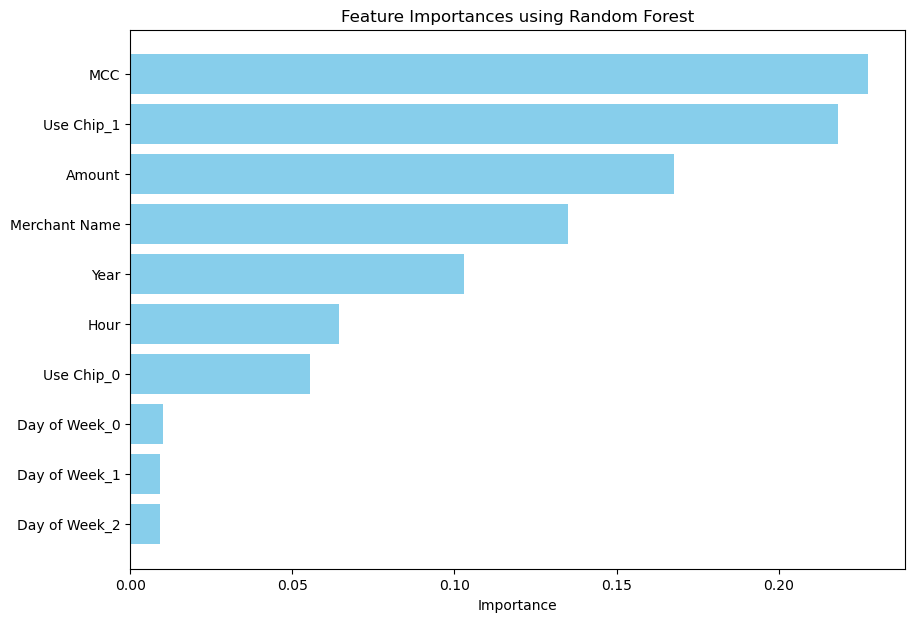

In [27]:
# Extract feature importances from the best random forest model
feature_importance = best_rf.feature_importances_
features = X_train.columns

# Sort the feature importances and their corresponding feature names
sorted_idx = feature_importance.argsort()

# Plot horizontal bar chart
plt.figure(figsize=(10, 7))
plt.barh(features[sorted_idx], feature_importance[sorted_idx], align='center', color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances using Random Forest')
plt.show()

In [28]:
df_test = pd.read_csv('../data/processed/test.csv')

In [29]:
df_test = df_test[columns_to_select]

In [30]:
df_test = preprocessing_pipeline.transform(df_test)

In [32]:
X_test = df_test.drop(columns=['Is Fraud?'])
y_test = df_test['Is Fraud?']

In [33]:
df_test = None

In [34]:
test_prediction = best_rf.predict(X_test)

print("Random Forest Classifier Test Results:")
print(classification_report(y_test, test_prediction))
print(confusion_matrix(y_test, test_prediction))

Random Forest Classifier Test Results:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99   1721851
         1.0       0.03      0.52      0.06      2087

    accuracy                           0.98   1723938
   macro avg       0.52      0.75      0.52   1723938
weighted avg       1.00      0.98      0.99   1723938

[[1688946   32905]
 [   1006    1081]]


In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

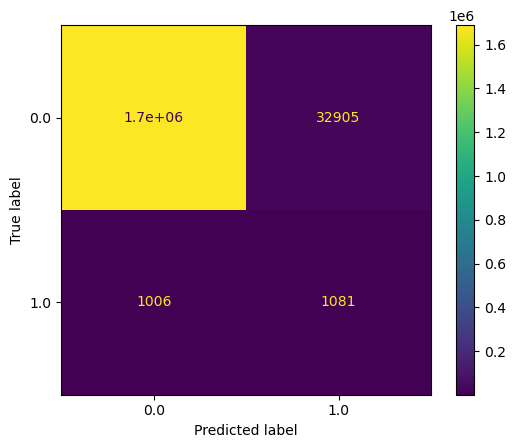

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_prediction),
                              display_labels=best_rf.classes_)
disp.plot()
plt.show()

In [37]:
amount_scaled = X_test['Amount'].values.reshape(-1, 1)
amount_rescaled = scaler.inverse_transform(amount_scaled)

In [38]:
X_test['Amount'] = scaler.inverse_transform(X_test['Amount'].values.reshape(-1, 1))

In [39]:
X_test['Prediction'] = test_prediction

In [40]:
X_test['Saved'] = X_test['Amount'] * X_test['Prediction']

In [41]:
X_test['Saved'].sum()

1763056.509999999

In [42]:
X_test['Amount'].sum()

73682938.67

In [43]:
saved_ratio = X_test['Saved'].sum() / X_test['Amount'].sum()
saved_ratio

0.023927608505085688

### Проверим на всей обучающей выборке лучшую модель без undersampling

In [50]:
X = df_transformed[(df_transformed['Year'] == 2017) | (df_transformed['Year'] == 2018)].drop(columns=['Is Fraud?'])
y = df_transformed[(df_transformed['Year'] == 2017) | (df_transformed['Year'] == 2018)]['Is Fraud?']

In [51]:
rf_classifier = RandomForestClassifier(**grid_search.best_params_)
rf_classifier.fit(X, y)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Prediction
- Saved


In [78]:
X_test = preprocessing_pipeline.transform(X_test)

In [82]:
X_test = X_test.drop(columns=['Prediction', 'Saved'])

In [83]:
y_test_preds = rf_classifier.predict(X_test)

print("Random Forest Classifier Results:")
print(classification_report(y_test, y_test_preds))
print(confusion_matrix(y_test, y_test_preds))

Random Forest Classifier Results:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1721851
         1.0       0.49      0.13      0.20      2087

    accuracy                           1.00   1723938
   macro avg       0.74      0.56      0.60   1723938
weighted avg       1.00      1.00      1.00   1723938

[[1721571     280]
 [   1818     269]]


In [84]:
X_test['Amount'] = scaler.inverse_transform(X_test['Amount'].values.reshape(-1, 1))

In [85]:
X_test['Prediction'] = y_test_preds

In [90]:
X_test['Is Fraud'] = y_test

In [91]:
X_test['Saved'] = (X_test['Amount'] * X_test['Prediction'])*X_test['Is Fraud']

In [92]:
X_test['Saved'].sum()

1700420.08425038

In [93]:
X_test['Amount'].sum()

5977516895.259272

In [89]:
X_test

,Year,Hour,Amount,Merchant Name,MCC,Use Chip_0,Use Chip_1,Day of Week_0,Day of Week_1,Day of Week_2,Prediction,Saved
0,2019.0,0.0,9605.641176,-3.693651e+18,4814.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,2019.0,0.0,1535.466902,-6.160036e+18,4121.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2019.0,0.0,8055.225447,-4.282467e+18,4829.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,2019.0,0.0,2646.798486,-1.856939e+18,5192.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2019.0,0.0,8479.887120,4.722913e+18,5411.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1723933,2019.0,23.0,4850.231693,-4.282467e+18,4829.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1723934,2019.0,23.0,5517.671642,-2.451783e+17,5311.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1723935,2019.0,23.0,6274.050168,-5.162038e+18,5541.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1723936,2019.0,23.0,8498.315834,4.241336e+18,4814.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [75]:
saved_ratio = X_test['Saved'].sum() / X_test['Amount'].sum()
saved_ratio

0.0005481663672731174

In [76]:
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

2024/06/02 19:09:16 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/06/02 19:09:16 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

In [77]:
import mlflow
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("fraud_detection")

2024/06/02 19:10:09 INFO mlflow.tracking.fluent: Experiment with name 'fraud_detection' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/lakeo/Projects/mlds_fraud/notebooks/mlruns/1', creation_time=1717344609531, experiment_id='1', last_update_time=1717344609531, lifecycle_stage='active', name='fraud_detection', tags={}>

In [94]:
with mlflow.start_run():
    mlflow.set_tag("iteration","baseline")

    mlflow.log_param("sampling", "No sampling")
    mlflow.log_param("model", "Random Forest")
    
    mlflow.log_metric("Precision", 0.49)
    mlflow.log_metric("Recall", 0.13)
    mlflow.log_metric("FP", 280)
    mlflow.log_metric("Saved money", 1700420)
    
    

In [95]:
with mlflow.start_run():
    mlflow.set_tag("iteration","baseline")

    mlflow.log_param("sampling", "Undersampling 1:5")
    mlflow.log_param("model", "Random Forest")
    
    mlflow.log_metric("Precision", 0.03)
    mlflow.log_metric("Recall", 0.52)
    mlflow.log_metric("FP", 32905)
    mlflow.log_metric("Saved money", 1963056)
    